In [1]:
import os, sys
# insert parent directory at beginning of python search path
from pathlib import Path
current_path = os.getcwd()
parent_path = str(Path(current_path).parent)
sys.path.append(parent_path)

import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

from src.utils import rk4, jacobian, atleast_col_vector
from src.discrete_linear_kalman_filter import DiscreteLinearKalmanFilter

In [2]:
# Define functions
def f(x, u, w, t, params):
    assert x.shape == (3, 1)
    assert w.shape == (3, 1)
    rho0 = params['rho0']
    k = params['k']
    g = params['g']

    x = x.flatten()
    
    xdot1 = x[1] + w[0]
    xdot2 = rho0 * np.exp(-x[0]/k) * x[1]**2 / 2 * x[2] - g + w[1]
    xdot3 = w[2]

    xdot = np.array([[xdot1, xdot2, xdot3]]).T
    xdot = xdot.reshape((3, 1))
    assert xdot.shape == (3, 1)
    return xdot

def fdis(x, u, w, t, params):
    simfunc = lambda t, x: f(x, u, w, t, params)
    return rk4(simfunc, t, params['dt'], x)

def h(x, v, params):
    return x[0] + v

In [3]:
# Define process and measurement noise covariance matrices
Q = np.diag([1e-9, 1e-9, 1e-9])
R = 100 * np.eye(1)

# Parameters
rho0 = 0.0034
g = 32.2
k = 22000

# Time parameters
tf = 30
dt = 0.0004
tspan = np.arange(0, tf + dt, dt)

params = {'rho0': rho0, 'g': g, 'k': k, 'dt': dt}


# Initial conditions
x0 = np.array([[100000, -6000, 1/2000]]).T
xhat0 = np.array([[100010, -6100, 1/2500]]).T
P0 = np.array([[500, 0, 0],
               [0, 20000, 0],
               [0, 0, 1/250000]])
u = np.atleast_2d(0)

# Create multivariate normal distributions for process and measurement noise
process_noise_pd = multivariate_normal([0, 0, 0], Q)
meas_noise_pd = multivariate_normal(0, R)

In [4]:
# create kalman filter object
def Ffunc(x0, u, params):
    assert x0.shape == (3,1)
    Jac = jacobian(lambda x: fdis(x, u, np.zeros((3,1)), 0, params), x0)
    return Jac

def Hfunc(x, u, params):
    assert x.shape == (3,1)
    Jac = np.array([[1, 0, 0]])
    return Jac

F = Ffunc(x0, u, params)
Ftrue = np.array([[1, 0.004, 0],
              [0, 1, 0.2599],
              [0, 0, 1]])
G = np.zeros((3,1))
H = Hfunc(x0, u, params)
kf = DiscreteLinearKalmanFilter(F, G, H, Q, R, xhat0, P0)
print(F)
print(Ftrue)


[[1.00000005e+00 4.00032150e-04 5.19503374e-05]
 [0.00000000e+00 9.99999957e-01 2.59878407e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[1.     0.004  0.    ]
 [0.     1.     0.2599]
 [0.     0.     1.    ]]


In [5]:
# simulate
xdim=  x0.shape[0]
tdim = tspan.shape[0]
dStore = {'x': np.zeros((xdim,tdim)), 'xhat': np.zeros((xdim,tdim)), 'P': P0}
x = x0
for i, t in enumerate(tspan):   
    # Simulate the system
    w = process_noise_pd.rvs().reshape((3, 1))
    simfunc = lambda t, x: f(x, u, w, t, params)
    x = rk4(simfunc, t, params['dt'], x)

    # Simulate the measurement
    v = meas_noise_pd.rvs()
    z = h(x, v, params)
    z = atleast_col_vector(z)
    
    # Prediction step of Kalman filter
    kf.predict(u)
    
    # Update step of Kalman filter
    kf.update(z,u,params)
    
    # Store estimate
    dStore['x'][:,i] = x.flatten()
    dStore['xhat'][:,i] = kf.x_hat.flatten()

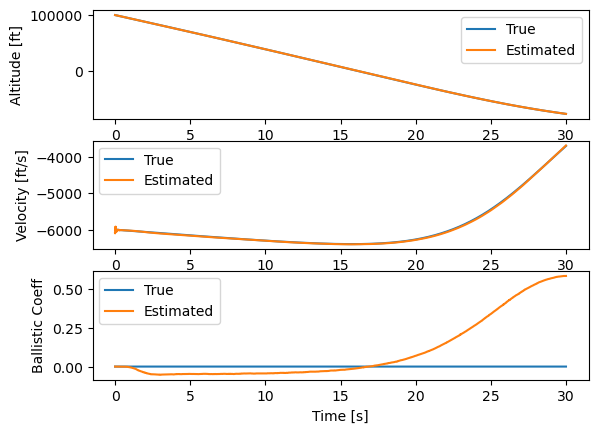

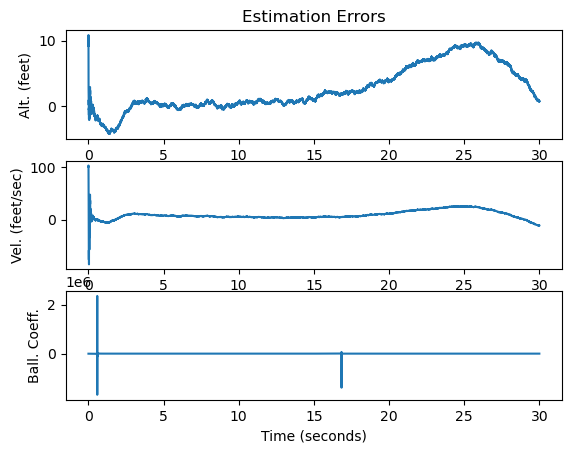

In [7]:
# Plot estimates
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(3, 1, 1)
plt.plot(tspan, dStore['x'][0, :], label='True')
plt.plot(tspan, dStore['xhat'][0, :], label='Estimated')
plt.ylabel("Altitude [ft]")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(tspan, dStore['x'][1, :], label='True')
plt.plot(tspan, dStore['xhat'][1, :], label='Estimated')
plt.ylabel("Velocity [ft/s]")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(tspan, dStore['x'][2, :], label='True')
plt.plot(tspan, dStore['xhat'][2, :], label='Estimated')
plt.ylabel("Ballistic Coeff")
plt.xlabel("Time [s]")
plt.legend()

# Plot estimation errors
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(tspan, dStore['x'][0, :] - dStore['xhat'][0, :])
plt.ylabel('Alt. (feet)')
plt.title('Estimation Errors')

plt.subplot(3, 1, 2)
plt.plot(tspan, dStore['x'][1, :] - dStore['xhat'][1, :])
plt.ylabel('Vel. (feet/sec)')

plt.subplot(3, 1, 3)
plt.plot(tspan, 1/dStore['x'][2, :] - 1/dStore['xhat'][2, :])
plt.xlabel('Time (seconds)')
plt.ylabel('Ball. Coeff.')

plt.show()
